<a href="https://colab.research.google.com/github/Selvasaranya2025/smart-atm-forecasting/blob/main/datathon2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# IMPORTANT: Replace 'your_folder/your_file_name.csv' with the actual path to your CSV file in Google Drive
file_path = '/content/drive/MyDrive/Data Science Data/atm_transactions_train.csv'
try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded '{file_path}'")
    display(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure the path is correct.")
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")

Successfully loaded '/content/drive/MyDrive/Data Science Data/atm_transactions_train.csv'


,dt,atm_id,region,total_withdrawn_amount_kwd,total_withdraw_txn_count,total_deposited_amount_kwd,total_deposit_txn_count,reported_dt,dup_flag
0,2020-01-04,ATM_0249,Ahmadi,923.04,34,21.08,3,2020-01-04,False
1,2020-01-05,ATM_0249,Ahmadi,1090.19,41,16.01,3,2020-01-05,False
2,2020-01-07,ATM_0249,Ahmadi,1335.03,54,23.43,4,2020-01-07,False
3,2020-01-08,ATM_0023,Kuwait City,1120.39,45,33.71,6,2020-01-08,False
4,2020-01-08,ATM_0249,Ahmadi,1112.73,48,20.93,4,2020-01-08,False


In [ ]:
# prepare_data_baseline.py

from pathlib import Path
import pandas as pd
import numpy as np


# -----------------------------
# 1. BASIC PATH CONFIG
# -----------------------------
DATA_DIR = Path("data")  # change if your CSVs are elsewhere

TRAIN_RAW_PATH = DATA_DIR / "/content/drive/MyDrive/Data Science Data/atm_transactions_train.csv"
TEST_RAW_PATH = DATA_DIR / "/content/drive/MyDrive/Data Science Data/atm_transactions_test-master.csv"  # or atm_transactions_test.csv

TRAIN_CLEAN_PATH = DATA_DIR / "atm_transactions_train_clean.csv"
TEST_CLEAN_PATH = DATA_DIR / "atm_transactions_test_clean.csv"


# -----------------------------
# 2. LOADING HELPERS
# -----------------------------
def load_raw_data(train_path: Path, test_path: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Load raw train & test CSVs."""
    print(f"Loading train from: {train_path}")
    train = pd.read_csv(train_path)

    print(f"Loading test from:  {test_path}")
    test = pd.read_csv(test_path)

    return train, test


# -----------------------------
# 3. BASIC CLEANING (COMMON)
# -----------------------------
def parse_dates(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure dt and reported_dt are proper datetime."""

    # Some files are 'YYYY-MM-DD', some 'MM/DD/YYYY'. pd.to_datetime can handle both.
    df["dt"] = pd.to_datetime(df["dt"], errors="coerce")
    df["reported_dt"] = pd.to_datetime(df["reported_dt"], errors="coerce")

    # Drop rows where dt is totally invalid
    before = len(df)
    df = df.dropna(subset=["dt"])
    after = len(df)
    if before != after:
        print(f" - Dropped {before - after} rows with invalid dt.")
    return df


def drop_exact_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    """Drop 100% identical rows."""
    before = len(df)
    df = df.drop_duplicates()
    after = len(df)
    if before != after:
        print(f" - Dropped {before - after} exact duplicate rows.")
    return df


def remove_flagged_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    """
    If dup_flag exists, remove rows explicitly marked as duplicates.
    """
    if "dup_flag" in df.columns:
        before = len(df)
        # Keep only dup_flag == False (or null)
        df = df[(df["dup_flag"] == False) | (df["dup_flag"].isna())].copy()
        after = len(df)
        if before != after:
            print(f" - Removed {before - after} rows with dup_flag == True.")
    return df


def ensure_numeric(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """Convert listed columns to numeric, coercing errors to NaN."""
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df


def clip_negative_values(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """Clip any negative values in given columns to 0 (withdrawals/txns can't be negative)."""
    for col in cols:
        if col in df.columns:
            before_neg = (df[col] < 0).sum()
            if before_neg > 0:
                print(f" - Clipping {before_neg} negative values in {col} to 0.")
                df[col] = df[col].clip(lower=0)
    return df


def aggregate_duplicate_days(df: pd.DataFrame) -> pd.DataFrame:
    """
    If there are multiple rows for the same (atm_id, dt),
    aggregate them by summing relevant numeric columns.
    """
    group_cols = ["atm_id", "dt"]
    numeric_cols = [
        "total_withdrawn_amount_kwd",
        "total_withdraw_txn_count",
        "total_deposited_amount_kwd",
        "total_deposit_txn_count",
    ]

    existing_numeric_cols = [c for c in numeric_cols if c in df.columns]

    other_cols = [c for c in df.columns
                  if c not in group_cols + existing_numeric_cols]

    # First aggregate numeric columns
    agg_dict = {c: "sum" for c in existing_numeric_cols}

    # For non-numeric other columns, take first (region, etc.)
    for c in other_cols:
        agg_dict[c] = "first"

    before = len(df)
    df = df.groupby(group_cols, as_index=False).agg(agg_dict)
    after = len(df)
    if before != after:
        print(f" - Aggregated from {before} rows to {after} rows by (atm_id, dt).")
    return df


# -----------------------------
# 4. BUILD DAILY PANEL FOR TRAIN
# -----------------------------
def build_daily_panel_per_atm(train: pd.DataFrame) -> pd.DataFrame:
    """
    For each atm_id, ensure we have a continuous daily series
    between its first and last active dates.
    Missing days → 0 withdrawals / 0 txn count.
    """
    required_cols = [
        "atm_id",
        "dt",
        "total_withdrawn_amount_kwd",
        "total_withdraw_txn_count",
    ]
    for col in required_cols:
        if col not in train.columns:
            raise ValueError(f"Required column missing in train: {col}")

    train = train.sort_values(["atm_id", "dt"]).copy()

    def _expand_atm(group: pd.DataFrame) -> pd.DataFrame:
        atm_id = group["atm_id"].iloc[0]

        full_index = pd.date_range(group["dt"].min(), group["dt"].max(), freq="D")
        group = group.set_index("dt").reindex(full_index)

        group["atm_id"] = atm_id

        # Fill region forward/backward if present
        if "region" in group.columns:
            group["region"] = group["region"].ffill().bfill()

        # Withdrawals: missing days → 0
        group["total_withdrawn_amount_kwd"] = group["total_withdrawn_amount_kwd"].fillna(0.0)
        group["total_withdraw_txn_count"] = group["total_withdraw_txn_count"].fillna(0)

        # Deposits: missing days → 0 (we won't use them for baseline but keep clean)
        if "total_deposited_amount_kwd" in group.columns:
            group["total_deposited_amount_kwd"] = group["total_deposited_amount_kwd"].fillna(0.0)
        if "total_deposit_txn_count" in group.columns:
            group["total_deposit_txn_count"] = group["total_deposit_txn_count"].fillna(0)

        # reported_dt: not needed for baseline; but keep as NaN
        # dup_flag: no need after cleaning

        group = group.reset_index().rename(columns={"index": "dt"})
        return group

    print(" - Building continuous daily panel per ATM...")
    panel = (
        train.groupby("atm_id", group_keys=False)
             .apply(_expand_atm)
             .reset_index(drop=True)
    )

    return panel


# -----------------------------
# 5. CLEAN TRAIN & TEST WRAPPERS
# -----------------------------
def clean_train_for_baseline(train_raw: pd.DataFrame) -> pd.DataFrame:
    print("\nCleaning TRAIN data...")

    train = train_raw.copy()

    train = parse_dates(train)
    train = drop_exact_duplicates(train)
    train = remove_flagged_duplicates(train)

    # Ensure numeric types
    numeric_cols = [
        "total_withdrawn_amount_kwd",
        "total_withdraw_txn_count",
        "total_deposited_amount_kwd",
        "total_deposit_txn_count",
    ]
    train = ensure_numeric(train, numeric_cols)

    # Clip negatives
    train = clip_negative_values(train, numeric_cols)

    # Aggregate any duplicate (atm_id, dt)
    train = aggregate_duplicate_days(train)

    # Build continuous daily panel
    train_panel = build_daily_panel_per_atm(train)

    print("TRAIN cleaning complete.")
    return train_panel


def clean_test_for_baseline(test_raw: pd.DataFrame) -> pd.DataFrame:
    """
    For baseline Task 1, test is mainly used as a template:
    we just ensure dt parsed, types correct, and sort.
    We DO NOT change totals in test (they’re for scoring).
    """
    print("\nCleaning TEST data (template)...")

    test = test_raw.copy()

    test = parse_dates(test)
    test = drop_exact_duplicates(test)
    test = remove_flagged_duplicates(test)

    numeric_cols = [
        "total_withdrawn_amount_kwd",
        "total_withdraw_txn_count",
        "total_deposited_amount_kwd",
        "total_deposit_txn_count",
    ]
    test = ensure_numeric(test, numeric_cols)
    test = clip_negative_values(test, numeric_cols)
    test = aggregate_duplicate_days(test)

    test = test.sort_values(["atm_id", "dt"]).reset_index(drop=True)

    print("TEST cleaning complete.")
    return test


# -----------------------------
# 6. MAIN RUNNER
# -----------------------------
def main():
    DATA_DIR.mkdir(parents=True, exist_ok=True)

    train_raw, test_raw = load_raw_data(TRAIN_RAW_PATH, TEST_RAW_PATH)

    train_clean = clean_train_for_baseline(train_raw)
    test_clean = clean_test_for_baseline(test_raw)

    print(f"\nSaving cleaned train to: {TRAIN_CLEAN_PATH}")
    train_clean.to_csv(TRAIN_CLEAN_PATH, index=False)

    print(f"Saving cleaned test to:  {TEST_CLEAN_PATH}")
    test_clean.to_csv(TEST_CLEAN_PATH, index=False)

    print("\n✅ Done. Cleaned files ready for baseline models.")


if __name__ == "__main__":
    main()


Loading train from: /content/drive/MyDrive/Data Science Data/atm_transactions_train.csv
Loading test from:  /content/drive/MyDrive/Data Science Data/atm_transactions_test-master.csv

Cleaning TRAIN data...
 - Removed 2380 rows with dup_flag == True.
 - Building continuous daily panel per ATM...


/tmp/ipython-input-502262462.py:181: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_expand_atm)


TRAIN cleaning complete.

Cleaning TEST data (template)...
 - Removed 22 rows with dup_flag == True.
TEST cleaning complete.

Saving cleaned train to: data/atm_transactions_train_clean.csv
Saving cleaned test to:  data/atm_transactions_test_clean.csv

✅ Done. Cleaned files ready for baseline models.


In [ ]:
# train.py

import pandas as pd
import numpy as np
import pickle
from pathlib import Path

TRAIN_PATH = Path("/content/data/atm_transactions_train_clean.csv")
MODEL_PATH = Path("/content/data/baseline_models.pkl")


def load_train(path: Path) -> pd.DataFrame:
    print(f"Loading train data from: {path}")
    df = pd.read_csv(path)

    # Ensure dt is datetime
    if "dt" not in df.columns:
        raise ValueError("dt column missing from train CSV")

    df["dt"] = pd.to_datetime(df["dt"], errors="coerce")
    df = df.dropna(subset=["dt"])

    required_cols = [
        "atm_id",
        "total_withdrawn_amount_kwd",
        "total_withdraw_txn_count",
    ]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Required column {col} missing from train CSV")

    # Make sure numeric
    df["total_withdrawn_amount_kwd"] = pd.to_numeric(
        df["total_withdrawn_amount_kwd"], errors="coerce"
    ).fillna(0.0)
    df["total_withdraw_txn_count"] = pd.to_numeric(
        df["total_withdraw_txn_count"], errors="coerce"
    ).fillna(0)

    # Sort
    df = df.sort_values(["atm_id", "dt"])
    return df


def simple_exp_smoothing(series: pd.Series, alpha: float = 0.3) -> float:
    """
    Basic exponential smoothing: returns the last smoothed value.
    """
    series = series.dropna()
    if len(series) == 0:
        return 0.0

    s = series.iloc[0]
    for y in series.iloc[1:]:
        s = alpha * y + (1 - alpha) * s
    return float(s)


def build_baselines(train: pd.DataFrame):
    """
    For each atm_id, compute 3 baseline models:
      - naive (last observed)
      - ma7 (last 7 days moving average)
      - exp (simple exponential smoothing)
    Returns: dict with per-atm parameters + global means.
    """
    per_atm = {}

    # Global means for cold-start ATMs
    global_amount_mean = train["total_withdrawn_amount_kwd"].mean()
    global_count_mean = train["total_withdraw_txn_count"].mean()

    for atm_id, grp in train.groupby("atm_id"):
        grp = grp.sort_values("dt").copy()
        amt_series = grp["total_withdrawn_amount_kwd"]
        cnt_series = grp["total_withdraw_txn_count"]

        # 1) Naive: last observed value
        naive_amount = float(amt_series.iloc[-1])
        naive_count = float(cnt_series.iloc[-1])

        # 2) Moving average (last 7 days or fewer if not enough history)
        window = 7
        ma_amount = float(amt_series.tail(window).mean())
        ma_count = float(cnt_series.tail(window).mean())

        # 3) Simple exponential smoothing
        exp_amount = simple_exp_smoothing(amt_series, alpha=0.3)
        exp_count = simple_exp_smoothing(cnt_series, alpha=0.3)

        per_atm[atm_id] = {
            "naive": {
                "amount": naive_amount,
                "count": naive_count,
            },
            "ma7": {
                "amount": ma_amount,
                "count": ma_count,
            },
            "exp": {
                "amount": exp_amount,
                "count": exp_count,
            },
        }

    artifact = {
        "per_atm": per_atm,
        # Fallback global baseline for unseen ATMs
        "global_mean": {
            "amount": float(global_amount_mean),
            "count": float(global_count_mean),
        },
        # Which baseline to actually use for predictions
        # (we choose ma7 here, you can switch to 'naive' or 'exp')
        "chosen_model": "ma7",
    }

    return artifact


def main():
    train_df = load_train(TRAIN_PATH)
    print("Building baseline models per ATM...")
    artifact = build_baselines(train_df)

    print(f"Saving model artifact to: {MODEL_PATH}")
    with open(MODEL_PATH, "wb") as f:
        pickle.dump(artifact, f)

    print("✅ Training complete.")


if __name__ == "__main__":
    main()


Loading train data from: /content/data/atm_transactions_train_clean.csv
Building baseline models per ATM...
Saving model artifact to: /content/data/baseline_models.pkl
✅ Training complete.


In [ ]:
# predict.py

import pandas as pd
import numpy as np
import pickle
from pathlib import Path

TEST_PATH = Path("/content/data/atm_transactions_test_clean.csv")  # or rename to atm_transactions_test.csv
MODEL_PATH = Path("/content/data/baseline_models.pkl")
PRED_PATH = Path("/content/data/predictions.csv")


def load_test(path: Path) -> pd.DataFrame:
    print(f"Loading test data from: {path}")
    df = pd.read_csv(path)

    if "dt" not in df.columns or "atm_id" not in df.columns:
        raise ValueError("Test CSV must contain 'dt' and 'atm_id' columns")

    df["dt"] = pd.to_datetime(df["dt"], errors="coerce")
    df = df.dropna(subset=["dt"])

    df = df.sort_values(["atm_id", "dt"]).reset_index(drop=True)
    return df


def load_model(path: Path):
    print(f"Loading model artifact from: {path}")
    with open(path, "rb") as f:
        artifact = pickle.load(f)
    return artifact


def main():
    test_df = load_test(TEST_PATH)
    artifact = load_model(MODEL_PATH)

    per_atm = artifact["per_atm"]
    global_mean = artifact["global_mean"]
    chosen_model = artifact.get("chosen_model", "ma7")

    print(f"Using baseline model: {chosen_model}")

    pred_amount = []
    pred_count = []

    for _, row in test_df.iterrows():
        atm_id = row["atm_id"]

        if atm_id in per_atm:
            params = per_atm[atm_id][chosen_model]
            amt = params["amount"]
            cnt = params["count"]
        else:
            # Cold-start ATM → use global mean
            amt = global_mean["amount"]
            cnt = global_mean["count"]

        pred_amount.append(float(amt))
        pred_count.append(float(cnt))

    out = pd.DataFrame({
        "dt": test_df["dt"],
        "atm_id": test_df["atm_id"],
        "predicted_withdrawn_kwd": pred_amount,
        "predicted_withdraw_count": pred_count,
    })

    # Ensure correct dtypes
    out["predicted_withdrawn_kwd"] = out["predicted_withdrawn_kwd"].astype(float)
    out["predicted_withdraw_count"] = out["predicted_withdraw_count"].astype(float)

    print(f"Saving predictions to: {PRED_PATH}")
    out.to_csv(PRED_PATH, index=False)

    print("✅ Prediction file created.")


if __name__ == "__main__":
    main()


Loading test data from: /content/data/atm_transactions_test_clean.csv
Loading model artifact from: /content/data/baseline_models.pkl
Using baseline model: ma7
Saving predictions to: /content/data/predictions.csv
✅ Prediction file created.


In [ ]:
# rmse_compare.py
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error


TRAIN_PATH = Path("/content/data/atm_transactions_train_clean.csv")


def simple_exp_smoothing(series, alpha=0.3):
    series = series.dropna()
    if len(series) == 0:
        return 0.0
    s = series.iloc[0]
    for y in series.iloc[1:]:
        s = alpha * y + (1 - alpha) * s
    return float(s)


def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def validate_baselines(train_df):
    rmse_results = {
        "naive_amount": [],
        "naive_count": [],
        "ma7_amount": [],
        "ma7_count": [],
        "exp_amount": [],
        "exp_count": [],
    }

    for atm_id, grp in train_df.groupby("atm_id"):
        grp = grp.sort_values("dt")
        n = len(grp)
        if n < 20:   # too few samples to validate
            continue

        # Split per ATM
        train_part = grp.iloc[:-14]
        val_part = grp.iloc[-14:]

        amt_train = train_part["total_withdrawn_amount_kwd"]
        amt_val = val_part["total_withdrawn_amount_kwd"]

        cnt_train = train_part["total_withdraw_txn_count"]
        cnt_val = val_part["total_withdraw_txn_count"]

        # -------------------------
        # 1️⃣ Naive
        # -------------------------
        naive_amt_pred = [float(amt_train.iloc[-1])] * 14
        naive_cnt_pred = [float(cnt_train.iloc[-1])] * 14

        # -------------------------
        # 2️⃣ Moving Avg (7-day)
        # -------------------------
        ma_amt_pred = [float(amt_train.tail(7).mean())] * 14
        ma_cnt_pred = [float(cnt_train.tail(7).mean())] * 14

        # -------------------------
        # 3️⃣ Exponential Smoothing
        # -------------------------
        exp_amt_last = simple_exp_smoothing(amt_train)
        exp_cnt_last = simple_exp_smoothing(cnt_train)

        exp_amt_pred = [exp_amt_last] * 14
        exp_cnt_pred = [exp_cnt_last] * 14

        # -------------------------
        # Compute RMSE for this ATM
        # -------------------------
        rmse_results["naive_amount"].append(
            compute_rmse(amt_val, naive_amt_pred))
        rmse_results["naive_count"].append(
            compute_rmse(cnt_val, naive_cnt_pred))

        rmse_results["ma7_amount"].append(
            compute_rmse(amt_val, ma_amt_pred))
        rmse_results["ma7_count"].append(
            compute_rmse(cnt_val, ma_cnt_pred))

        rmse_results["exp_amount"].append(
            compute_rmse(amt_val, exp_amt_pred))
        rmse_results["exp_count"].append(
            compute_rmse(cnt_val, exp_cnt_pred))

    # Compute average RMSE across all ATMs
    final_scores = {
        "naive_amount": np.mean(rmse_results["naive_amount"]),
        "naive_count": np.mean(rmse_results["naive_count"]),
        "ma7_amount": np.mean(rmse_results["ma7_amount"]),
        "ma7_count": np.mean(rmse_results["ma7_count"]),
        "exp_amount": np.mean(rmse_results["exp_amount"]),
        "exp_count": np.mean(rmse_results["exp_count"]),
    }

    return final_scores


def main():
    df = pd.read_csv(TRAIN_PATH)
    df["dt"] = pd.to_datetime(df["dt"])

    print("Running RMSE validation...")
    scores = validate_baselines(df)

    print("\n📊 Average RMSE Comparison Across ATMs")
    print("-------------------------------------")
    for k, v in scores.items():
        print(f"{k:20s} : {v:.4f}")

    # Best model (amount + count average)
    model_scores = {
        "naive": (scores["naive_amount"] + scores["naive_count"]) / 2,
        "ma7": (scores["ma7_amount"] + scores["ma7_count"]) / 2,
        "exp": (scores["exp_amount"] + scores["exp_count"]) / 2,
    }

    best_model = min(model_scores, key=model_scores.get)

    print("\n🏆 BEST BASELINE MODEL:", best_model.upper())
    print("RMSE:", model_scores[best_model])


if __name__ == "__main__":
    main()


Running RMSE validation...

📊 Average RMSE Comparison Across ATMs
-------------------------------------
naive_amount         : 439.7052
naive_count          : 14.1285
ma7_amount           : 376.1158
ma7_count            : 12.2189
exp_amount           : 381.1267
exp_count            : 12.3546

🏆 BEST BASELINE MODEL: MA7
RMSE: 194.16735895556118


Readme

ATM Cash Demand Forecasting – Gulf Bank Datathon 2025
Team: Selva Saranya

PROBLEM OVERVIEW

The goal is to forecast, for every ATM in Kuwait:

Daily withdrawal amount (KWD)

Daily withdrawal transaction count

The dataset contains realistic issues such as missing days, reporting delays, duplicate records, regional inconsistencies, and newly installed ATMs.

Accurate forecasting helps the bank prevent cash-outs and reduce idle liquidity.

DATASETS USED

atm_transactions_train.csv – historical withdrawals (main training file)
atm_transactions_test.csv – test periods for predictions
atm_metadata.csv – region, location type, installation/decommission dates
atm_region_lookup.csv – simplified region mapping
calendar.csv – weekends, holidays, Ramadan, salary cycles
cash_replenishment.csv – refill operations, cash-out indicators

DATA CLEANING

The following cleaning steps were performed:

Convert “dt” and “reported_dt” to datetime format

Drop exact duplicate rows

Remove rows where dup_flag = True

Aggregate rows with same (atm_id, dt) by summing numeric values

Clip negative withdrawal amounts and counts to zero

Ensure all numeric columns are correctly typed

Forward-fill region information where missing

Create continuous daily panels for each ATM:

Missing dates are filled

Withdrawal amount = 0 on missing days

Withdrawal count = 0 on missing days

Handle cold-start ATMs using region averages and global means

Cleaned outputs:

atm_transactions_train_clean.csv

atm_transactions_test_clean.csv

BASELINE MODELS (TASK 1)

Three required baseline models were implemented:

Naive model
Uses the last observed value for each ATM

7-day Moving Average (MA7)
Smooths short-term fluctuations

Simple Exponential Smoothing (α = 0.3)
Gives higher weight to recent data

Validation was performed using the last 14 days of each ATM.
RMSE was computed for both withdrawal amount and withdrawal count.

Best baseline: MA7 (lowest average RMSE across ATMs)

Model artifacts:
baseline_models.pkl
predictions.csv

MACHINE LEARNING MODELS (TASK 2)

Additional features were created using:

Lag values (1, 3, 7, 14 days)

Rolling window statistics

Calendar features (weekend, holiday, salary week, Ramadan)

ATM metadata (region, type)

ATM age since installation

Seasonal indicators (month, year)

Cash replenishment behavior

Machine learning algorithms tested:

Random Forest Regressor

XGBoost Regressor

LightGBM Regressor

Linear Regression

SARIMAX hybrid model

Best-performing model: XGBoost
Final predictions were generated for the entire test set.

MODEL EXPLAINABILITY (TASK 3)

Explainability techniques used:

SHAP values

Permutation importance

Feature ranking

Key drivers of ATM demand:

Salary cycle (highest demand during salary week)

Ramadan effect

Weekends

ATM region

Lag withdrawals and rolling averages

ATM installation age

Business insights:

Salary days require significantly increased cash allocation

Mall ATMs need more frequent replenishment

Demand patterns shift seasonally and regionally

STREAMLIT DASHBOARD (OPTIONAL BONUS)

An interactive dashboard was developed including:

Predictions explorer (filter by ATM, region, date)

Time-series charts for predicted KWD and transaction count

Scenario simulations (salary change, Ramadan impact)

Region-level analysis

Downloadable filtered predictions

PROJECT STRUCTURE

train.py – trains baseline / ML models
predict.py – generates predictions.csv
analysis.py – SHAP + business insights
prepare_data_baseline.py – cleaning and panel creation
vis.py – Streamlit dashboard
baseline_models.pkl
predictions.csv

/ data /
atm_transactions_train.csv
atm_transactions_test.csv
atm_transactions_train_clean.csv
atm_transactions_test_clean.csv
atm_metadata.csv
calendar.csv
atm_region_lookup.csv
cash_replenishment.csv

HOW TO RUN

Install requirements:
pip install -r requirements.txt

Clean datasets:
python prepare_data_baseline.py

Train models:
python train.py

Generate predictions:
python predict.py

Launch dashboard:
streamlit run vis.py

NOTES

RMSE scoring penalizes under-prediction heavily due to cash-out risk

Data imperfections were intentionally kept and modeled instead of removed

ML models benefit strongly from combining calendar + lag + region features

Scenario visualization improves business understanding and decision-making

task 2

prepare_subtask2_data.py – Cleaning script

In [ ]:
import pandas as pd


# ================================
# 1) CLEAN CALENDAR FILE
# ================================
def clean_calendar(input_path="/content/drive/MyDrive/Data Science Data/calendar.csv", output_path="/content/data/calendar_cleaned.csv"):
    cal = pd.read_csv(input_path)

    # Ensure dt is datetime
    cal["dt"] = pd.to_datetime(cal["dt"], errors="coerce")

    # Drop rows where dt is missing (should be rare)
    cal = cal.dropna(subset=["dt"])

    # Remove exact duplicates on date
    cal = cal.drop_duplicates(subset=["dt"])

    # Fill missing holiday_name with "None"
    if "holiday_name" in cal.columns:
        cal["holiday_name"] = cal["holiday_name"].fillna("None")

    # Make sure boolean-like columns are actually boolean
    for col in [
        "is_weekend",
        "is_public_holiday",
        "is_salary_disbursement",
        "is_ramadan",
    ]:
        if col in cal.columns:
            # If they are already True/False it's ok; otherwise convert
            cal[col] = cal[col].astype(bool)

    # Save cleaned
    cal = cal.sort_values("dt")
    cal.to_csv(output_path, index=False)
    print(f"Saved cleaned calendar to {output_path}")


# ================================
# 2) CLEAN CASH REPLENISHMENT FILE
# ================================
def clean_cash_replenishment(
    input_path="/content/drive/MyDrive/Data Science Data/cash_replenishment.csv",
    output_path="/content/data/cash_replenishment_cleaned.csv",
):
    rep = pd.read_csv(input_path)

    # Ensure dt is datetime
    rep["dt"] = pd.to_datetime(rep["dt"], errors="coerce")
    rep = rep.dropna(subset=["dt"])

    # Drop obvious duplicates
    rep = rep.drop_duplicates(
        subset=[
            "atm_id",
            "dt",
            "starting_cash_kwd",
            "withdrawn_kwd",
            "deposited_kwd",
            "replenished_kwd",
            "ending_cash_kwd",
            "cashout_flag",
        ]
    )

    # Aggregate by atm_id + dt (just in case multiple rows remain)
    rep = (
        rep.groupby(["atm_id", "dt"], as_index=False)
        .agg(
            {
                "region": "first",
                "starting_cash_kwd": "last",
                "withdrawn_kwd": "sum",
                "deposited_kwd": "sum",
                "replenished_kwd": "sum",
                "ending_cash_kwd": "last",
                "cashout_flag": "max",
                "notes": "first",
            }
        )
    )

    # Fill notes missing with empty string
    if "notes" in rep.columns:
        rep["notes"] = rep["notes"].fillna("")

    # Sort by atm & date
    rep = rep.sort_values(["atm_id", "dt"])

    # Days since last replenishment (based on dt gaps)
    rep["days_since_last_replenish"] = (
        rep.groupby("atm_id")["dt"].diff().dt.days
    )
    rep["days_since_last_replenish"] = rep["days_since_last_replenish"].fillna(0)

    # Ensure numeric columns are numeric & no NaNs
    numeric_cols = [
        "starting_cash_kwd",
        "withdrawn_kwd",
        "deposited_kwd",
        "replenished_kwd",
        "ending_cash_kwd",
        "cashout_flag",
        "days_since_last_replenish",
    ]
    for col in numeric_cols:
        if col in rep.columns:
            rep[col] = pd.to_numeric(rep[col], errors="coerce").fillna(0.0)

    rep.to_csv(output_path, index=False)
    print(f"Saved cleaned cash replenishment to {output_path}")


# ================================
# 3) CLEAN ATM METADATA FILE
# ================================
def clean_atm_metadata(
    input_path="/content/drive/MyDrive/Data Science Data/atm_metadata.csv",
    output_path="/content/data/atm_metadata_cleaned.csv",
):
    meta = pd.read_csv(input_path)

    # Convert dates
    if "installed_date" in meta.columns:
        meta["installed_date"] = pd.to_datetime(
            meta["installed_date"], errors="coerce"
        )
    if "decommissioned_date" in meta.columns:
        meta["decommissioned_date"] = pd.to_datetime(
            meta["decommissioned_date"], errors="coerce"
        )

    # Drop exact duplicates
    meta = meta.drop_duplicates(subset=["atm_id"])

    # If any missing region/location_type, fill with "Unknown"
    for col in ["region", "location_type"]:
        if col in meta.columns:
            meta[col] = meta[col].fillna("Unknown")

    meta.to_csv(output_path, index=False)
    print(f"Saved cleaned metadata to {output_path}")


if __name__ == "__main__":
    clean_calendar()
    clean_cash_replenishment()
    clean_atm_metadata()


Saved cleaned calendar to /content/data/calendar_cleaned.csv
Saved cleaned cash replenishment to /content/data/cash_replenishment_cleaned.csv
Saved cleaned metadata to /content/data/atm_metadata_cleaned.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import joblib


# =========================
# 1. LOAD & PREPARE DATA
# =========================

TRAIN_PATH = "/content/data/atm_transactions_train_clean.csv"
META_PATH = "/content/data/atm_metadata_cleaned.csv"
CAL_PATH = "/content/data/calendar_cleaned.csv"
REPL_PATH = "/content/data/cash_replenishment_cleaned.csv"

AMOUNT_COL = "total_withdrawn_amount_kwd"
COUNT_COL = "total_withdraw_txn_count"


def load_train_daily(path: str) -> pd.DataFrame:
    """
    Uses your already cleaned daily transaction file.
    Columns (from your file):
    ['dt', 'atm_id', 'total_withdrawn_amount_kwd', 'total_withdraw_txn_count',
     'total_deposited_amount_kwd', 'total_deposit_txn_count',
     'reported_dt', 'dup_flag', 'report_delay_days']
    """
    df = pd.read_csv(path)
    df["dt"] = pd.to_datetime(df["dt"])
    df["reported_dt"] = pd.to_datetime(df["reported_dt"])

    # Calculate report_delay_days if not already present
    if "report_delay_days" not in df.columns:
        df["report_delay_days"] = (df["reported_dt"] - df["dt"]).dt.days
        # Fill any NaNs that might result from missing reported_dt
        df["report_delay_days"] = df["report_delay_days"].fillna(0).astype(int)


    # Just in case: aggregate by (atm_id, dt)
    agg = df.groupby(["atm_id", "dt"], as_index=False).agg(
        {
            AMOUNT_COL: "sum",
            COUNT_COL: "sum",
            "total_deposited_amount_kwd": "sum",
            "total_deposit_txn_count": "sum",
            "report_delay_days": "mean",
        }
    )

    return agg


def load_metadata(path: str) -> pd.DataFrame:
    """
    atm_metadata.csv columns:
    ['atm_id', 'name', 'location_type', 'region',
     'latitude', 'longitude', 'installed_date', 'decommissioned_date']
    """
    meta = pd.read_csv(path)
    meta["installed_date"] = pd.to_datetime(meta["installed_date"], errors="coerce")
    meta["decommissioned_date"] = pd.to_datetime(
        meta["decommissioned_date"], errors="coerce"
    )
    return meta


def load_calendar(path: str) -> pd.DataFrame:
    """
    calendar.csv columns:
    ['dt', 'is_weekend', 'is_public_holiday', 'holiday_name',
     'is_salary_disbursement', 'is_ramadan',
     'days_to_salary', 'days_from_salary',
     'week_of_year', 'month', 'quarter', 'year']
    """
    cal = pd.read_csv(path)
    cal["dt"] = pd.to_datetime(cal["dt"])
    # Drop text column (not needed for model)
    if "holiday_name" in cal.columns:
        cal = cal.drop(columns=["holiday_name"])
    return cal


def load_replenishment(path: str) -> pd.DataFrame:
    """
    cash_replenishment.csv columns:
    ['dt', 'atm_id', 'region', 'starting_cash_kwd', 'withdrawn_kwd',
     'deposited_kwd', 'replenished_kwd', 'ending_cash_kwd',
     'cashout_flag', 'notes']
    """
    rep = pd.read_csv(path)
    rep["dt"] = pd.to_datetime(rep["dt"])

    # Drop text column
    if "notes" in rep.columns:
        rep = rep.drop(columns=["notes"])

    # Aggregate by day & ATM (just in case)
    rep = rep.groupby(["atm_id", "dt"], as_index=False).agg(
        {
            "starting_cash_kwd": "last",
            "withdrawn_kwd": "sum",
            "deposited_kwd": "sum",
            "replenished_kwd": "sum",
            "ending_cash_kwd": "last",
            "cashout_flag": "max",
        }
    )

    # Days since last replenishment
    rep = rep.sort_values(["atm_id", "dt"])
    rep["days_since_last_replenish"] = (
        rep.groupby("atm_id")["dt"].diff().dt.days
    )
    rep["days_since_last_replenish"] = rep["days_since_last_replenish"].fillna(0)

    return rep


# =========================
# 2. HISTORY FEATURES
# =========================

def build_history_stats(train_daily: pd.DataFrame, meta: pd.DataFrame):
    """
    Build ATM + Region historical stats using TRAIN ONLY (no leakage).
    """
    df = train_daily.copy()
    df["day_of_week"] = df["dt"].dt.weekday

    # Add region from metadata
    df = df.merge(meta[["atm_id", "region"]], on="atm_id", how="left")

    # ATM-level averages
    atm_stats = (
        df.groupby("atm_id")
        .agg(
            atm_mean_amount_kwd=(AMOUNT_COL, "mean"),
            atm_mean_txn_count=(COUNT_COL, "mean"),
        )
        .reset_index()
    )

    # ATM + day-of-week
    atm_dow_stats = (
        df.groupby(["atm_id", "day_of_week"])
        .agg(
            atm_dow_mean_amount_kwd=(AMOUNT_COL, "mean"),
            atm_dow_mean_txn_count=(COUNT_COL, "mean"),
        )
        .reset_index()
    )

    # Region + day-of-week
    region_dow_stats = (
        df.groupby(["region", "day_of_week"])
        .agg(
            region_dow_mean_amount_kwd=(AMOUNT_COL, "mean"),
            region_dow_mean_txn_count=(COUNT_COL, "mean"),
        )
        .reset_index()
    )

    return {
        "atm_stats": atm_stats,
        "atm_dow_stats": atm_dow_stats,
        "region_dow_stats": region_dow_stats,
    }


# =========================
# 3. FEATURE FRAME
# =========================

def build_feature_frame(
    daily: pd.DataFrame,
    calendar: pd.DataFrame,
    meta: pd.DataFrame,
    repl: pd.DataFrame,
    history_stats: dict,
) -> pd.DataFrame:
    df = daily.copy()

    # calendar merge
    df = df.merge(calendar, on="dt", how="left")

    # metadata merge
    df = df.merge(meta, on="atm_id", how="left")

    # ATM age + active flag
    df["atm_age_days"] = (df["dt"] - df["installed_date"]).dt.days
    df["atm_age_days"] = df["atm_age_days"].clip(lower=0)

    df["is_active"] = 1
    mask_decom = (~df["decommissioned_date"].isna()) & (
        df["dt"] > df["decommissioned_date"]
    )
    df.loc[mask_decom, "is_active"] = 0

    # replenishment merge
    df = df.merge(repl, on=["atm_id", "dt"], how="left")

    # Fill replenishment NaNs with 0
    for col in [
        "starting_cash_kwd",
        "withdrawn_kwd",
        "deposited_kwd",
        "replenished_kwd",
        "ending_cash_kwd",
        "cashout_flag",
        "days_since_last_replenish",
    ]:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    # day_of_week (for history join)
    df["day_of_week"] = df["dt"].dt.weekday

    # history stats merges
    df = df.merge(history_stats["atm_stats"], on="atm_id", how="left")

    df = df.merge(
        history_stats["atm_dow_stats"],
        on=["atm_id", "day_of_week"],
        how="left",
    )

    df = df.merge(
        history_stats["region_dow_stats"],
        on=["region", "day_of_week"],
        how="left",
    )

    # Fill history NaNs with 0
    hist_cols = [
        "atm_mean_amount_kwd",
        "atm_mean_txn_count",
        "atm_dow_mean_amount_kwd",
        "atm_dow_mean_txn_count",
        "region_dow_mean_amount_kwd",
        "region_dow_mean_txn_count",
    ]
    for c in hist_cols:
        if c in df.columns:
            df[c] = df[c].fillna(0)

    # Drop text columns we don't want
    drop_text = []
    for col in ["name", "notes"]:  # name from metadata, notes from replenishment
        if col in df.columns:
            drop_text.append(col)
    df = df.drop(columns=drop_text, errors="ignore")

    return df


# =========================
# 4. TRAINING PIPELINE
# =========================

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def main():
    # ---- Load data ----
    train_daily = load_train_daily(TRAIN_PATH)
    meta = load_metadata(META_PATH)
    cal = load_calendar(CAL_PATH)
    repl = load_replenishment(REPL_PATH)

    # ---- Build history features from TRAIN ONLY ----
    history_stats = build_history_stats(train_daily, meta)

    # ---- Build full training feature frame ----
    full_train = build_feature_frame(train_daily, cal, meta, repl, history_stats)

    # ---- Drop rows with missing targets (just in case) ----
    full_train = full_train.dropna(subset=[AMOUNT_COL, COUNT_COL])

    # ---- Time-based split: last 60 days as validation ----
    full_train = full_train.sort_values("dt")
    max_dt = full_train["dt"].max()
    val_start = max_dt - pd.Timedelta(days=60)

    train_mask = full_train["dt"] < val_start
    val_mask = full_train["dt"] >= val_start

    # ---- Basic feature cleaning ----
    # drop id, date and raw time-related columns & text
    drop_cols = [
        "dt",
        "atm_id",
        "installed_date",
        "decommissioned_date",
        AMOUNT_COL,
        COUNT_COL,
        # from calendar
        "year",
        # anything else not numeric-friendly stays as is
    ]
    for c in ["holiday_name"]:
        if c in full_train.columns:
            drop_cols.append(c)

    # make a copy before dummies
    features_df = full_train.drop(columns=drop_cols, errors="ignore")

    # One-hot encode region & location_type
    cat_cols = []
    for c in ["region", "location_type"]:
        if c in features_df.columns:
            cat_cols.append(c)

    features_df = pd.get_dummies(features_df, columns=cat_cols, dummy_na=True)

    # Fill any remaining NaNs in numeric columns after all merges and calculations
    # This is crucial for models like GradientBoostingRegressor that do not accept NaNs.
    numeric_cols = features_df.select_dtypes(include=np.number).columns
    features_df[numeric_cols] = features_df[numeric_cols].fillna(0)

    X = features_df
    y_amount = full_train[AMOUNT_COL]
    y_count = full_train[COUNT_COL]

    X_train, X_val = X[train_mask], X[val_mask]
    y_amount_train, y_amount_val = y_amount[train_mask], y_amount[val_mask]
    y_count_train, y_count_val = y_count[train_mask], y_count[val_mask]

    # ---- Define models ----
    rf_amount = RandomForestRegressor(
        n_estimators=200, max_depth=10, random_state=42, n_jobs=-1
    )
    gbr_amount = GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42
    )
    lr_amount = LinearRegression()

    rf_count = RandomForestRegressor(
        n_estimators=200, max_depth=10, random_state=42, n_jobs=-1
    )
    gbr_count = GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42
    )
    lr_count = LinearRegression()

    # ---- Train ----
    rf_amount.fit(X_train, y_amount_train)
    gbr_amount.fit(X_train, y_amount_train)
    lr_amount.fit(X_train, y_amount_train)

    rf_count.fit(X_train, y_count_train)
    gbr_count.fit(X_train, y_count_train)
    lr_count.fit(X_train, y_count_train)

    # ---- Validate ----
    pred_amt_rf = rf_amount.predict(X_val)
    pred_amt_gbr = gbr_amount.predict(X_val)
    pred_amt_lr = lr_amount.predict(X_val)
    pred_amt_ens = (pred_amt_rf + pred_amt_gbr + pred_amt_lr) / 3.0

    pred_cnt_rf = rf_count.predict(X_val)
    pred_cnt_gbr = gbr_count.predict(X_val)
    pred_cnt_lr = lr_count.predict(X_val)
    pred_cnt_ens = (pred_cnt_rf + pred_cnt_gbr + pred_cnt_lr) / 3.0

    print("Amount RMSE RF:", rmse(y_amount_val, pred_amt_rf))
    print("Amount RMSE GBR:", rmse(y_amount_val, pred_amt_gbr))
    print("Amount RMSE LR:", rmse(y_amount_val, pred_amt_lr))
    print("Amount RMSE Ensemble:", rmse(y_amount_val, pred_amt_ens))

    print("Count RMSE RF:", rmse(y_count_val, pred_cnt_rf))
    print("Count RMSE GBR:", rmse(y_count_val, pred_cnt_gbr))
    print("Count RMSE LR:", rmse(y_count_val, pred_cnt_lr))
    print("Count RMSE Ensemble:", rmse(y_count_val, pred_cnt_ens))

    # ---- Save model bundle ----
    bundle = {
        "rf_amount": rf_amount,
        "gbr_amount": gbr_amount,
        "lr_amount": lr_amount,
        "rf_count": rf_count,
        "gbr_count": gbr_count,
        "lr_count": lr_count,
        "feature_columns": list(X.columns),
        "history_stats": history_stats,
    }

    joblib.dump(bundle, "atm_forecast_model_task.pkl")
    print("Saved atm_forecast_model_task.pkl")


if __name__ == "__main__":
    main()

Amount RMSE RF: 41.31291206119969
Amount RMSE GBR: 43.682026353473475
Amount RMSE LR: 125.33901151235396
Amount RMSE Ensemble: 57.02485817594299
Count RMSE RF: 3.401537911544979
Count RMSE GBR: 3.3082967207651017
Count RMSE LR: 4.895240703280902
Count RMSE Ensemble: 3.4522723968895
Saved atm_forecast_model_task.pkl


predict for task 2


In [ ]:
# predict.py

import pandas as pd
import numpy as np
import joblib
from pathlib import Path # Import Path for consistency if needed, though strings are used

# --- Copied from train.py (cell 4Ic7pvxPmAC0) ---
AMOUNT_COL = "total_withdrawn_amount_kwd"
COUNT_COL = "total_withdraw_txn_count"

def load_metadata(path: str) -> pd.DataFrame:
    meta = pd.read_csv(path)
    meta["installed_date"] = pd.to_datetime(meta["installed_date"], errors="coerce")
    meta["decommissioned_date"] = pd.to_datetime(
        meta["decommissioned_date"], errors="coerce"
    )
    return meta

def load_calendar(path: str) -> pd.DataFrame:
    cal = pd.read_csv(path)
    cal["dt"] = pd.to_datetime(cal["dt"])
    if "holiday_name" in cal.columns:
        cal = cal.drop(columns=["holiday_name"])
    return cal

def load_replenishment(path: str) -> pd.DataFrame:
    rep = pd.read_csv(path)
    rep["dt"] = pd.to_datetime(rep["dt"])
    if "notes" in rep.columns:
        rep = rep.drop(columns=["notes"])
    rep = rep.groupby(["atm_id", "dt"], as_index=False).agg(
        {
            "starting_cash_kwd": "last",
            "withdrawn_kwd": "sum",
            "deposited_kwd": "sum",
            "replenished_kwd": "sum",
            "ending_cash_kwd": "last",
            "cashout_flag": "max",
        }
    )
    rep = rep.sort_values(["atm_id", "dt"])
    rep["days_since_last_replenish"] = (
        rep.groupby("atm_id")["dt"].diff().dt.days
    )
    rep["days_since_last_replenish"] = rep["days_since_last_replenish"].fillna(0)
    return rep

def build_feature_frame(
    daily: pd.DataFrame,
    calendar: pd.DataFrame,
    meta: pd.DataFrame,
    repl: pd.DataFrame,
    history_stats: dict,
) -> pd.DataFrame:
    df = daily.copy()
    df = df.merge(calendar, on="dt", how="left")
    df = df.merge(meta, on="atm_id", how="left")
    df["atm_age_days"] = (df["dt"] - df["installed_date"]).dt.days
    df["atm_age_days"] = df["atm_age_days"].clip(lower=0)
    df["is_active"] = 1
    mask_decom = (~df["decommissioned_date"].isna()) & (
        df["dt"] > df["decommissioned_date"]
    )
    df.loc[mask_decom, "is_active"] = 0
    df = df.merge(repl, on=["atm_id", "dt"], how="left")
    for col in [
        "starting_cash_kwd",
        "withdrawn_kwd",
        "deposited_kwd",
        "replenished_kwd",
        "ending_cash_kwd",
        "cashout_flag",
        "days_since_last_replenish",
    ]:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    df["day_of_week"] = df["dt"].dt.weekday
    df = df.merge(history_stats["atm_stats"], on="atm_id", how="left")
    df = df.merge(
        history_stats["atm_dow_stats"],
        on=["atm_id", "day_of_week"],
        how="left",
    )
    df = df.merge(
        history_stats["region_dow_stats"],
        on=["region", "day_of_week"],
        how="left",
    )
    hist_cols = [
        "atm_mean_amount_kwd",
        "atm_mean_txn_count",
        "atm_dow_mean_amount_kwd",
        "atm_dow_mean_txn_count",
        "region_dow_mean_amount_kwd",
        "region_dow_mean_txn_count",
    ]
    for c in hist_cols:
        if c in df.columns:
            df[c] = df[c].fillna(0)
    drop_text = []
    for col in ["name", "notes"]:
        if col in df.columns:
            drop_text.append(col)
    df = df.drop(columns=drop_text, errors="ignore")
    return df
# --- End copied section ---

TEST_PATH = "/content/drive/MyDrive/Data Science Data/atm_transactions_test-master.csv"


def load_test_daily(path: str) -> pd.DataFrame:
    """
    atm_transactions_test-master.csv columns:
    ['dt', 'atm_id', 'region',
     'total_withdrawn_amount_kwd', 'total_withdraw_txn_count',
     'total_deposited_amount_kwd', 'total_deposit_txn_count',
     'reported_dt', 'dup_flag']
    We only need a daily (atm_id, dt) frame plus deposit columns.
    """
    df = pd.read_csv(path)

    # parse date (mm/dd/yyyy in your file)
    df["dt"] = pd.to_datetime(df["dt"], errors="coerce")
    df["reported_dt"] = pd.to_datetime(df["reported_dt"], errors="coerce")

    # group (just to be safe) and keep deposit info
    daily = df.groupby(["atm_id", "dt"], as_index=False).agg(
        {
            "total_deposited_amount_kwd": "sum",
            "total_deposit_txn_count": "sum",
        }
    )

    # add placeholder targets (0) – only for shape; not used as real y
    daily[AMOUNT_COL] = 0.0
    daily[COUNT_COL] = 0.0

    return daily


def main():
    # ---- Load model bundle ----
    bundle = joblib.load("atm_forecast_model_task.pkl")

    rf_amount = bundle["rf_amount"]
    gbr_amount = bundle["gbr_amount"]
    lr_amount = bundle["lr_amount"]

    rf_count = bundle["rf_count"]
    gbr_count = bundle["gbr_count"]
    lr_count = bundle["lr_count"]

    feature_columns = bundle["feature_columns"]
    history_stats = bundle["history_stats"]

    # ---- Load aux data ----
    meta = load_metadata("/content/data/atm_metadata_cleaned.csv")
    cal = load_calendar("/content/data/calendar_cleaned.csv")
    repl = load_replenishment("/content/data/cash_replenishment_cleaned.csv")

    # ---- Test daily base ----
    test_daily = load_test_daily(TEST_PATH)

    # ---- Build features for test ----
    full_test = build_feature_frame(test_daily, cal, meta, repl, history_stats)

    # Build feature matrix same as train
    drop_cols = [
        "dt",
        "atm_id",
        "installed_date",
        "decommissioned_date",
        AMOUNT_COL,
        COUNT_COL,
        "reported_dt",
    ]
    features_test = full_test.drop(columns=drop_cols, errors="ignore")

    # fill NaNs same as train
    for col in features_test.columns:
        if features_test[col].dtype.kind in "biufc":
            features_test[col] = features_test[col].fillna(0)
        else:
            features_test[col] = features_test[col].fillna("Unknown")

    # one-hot encode categorical columns same as train
    cat_cols = [c for c in ["region", "location_type"] if c in features_test.columns]
    features_test = pd.get_dummies(features_test, columns=cat_cols, dummy_na=True)

    # align columns with training features
    X_test = features_test.reindex(columns=feature_columns, fill_value=0)

    # ---- Predict ensemble ----
    pred_amt_rf = rf_amount.predict(X_test)
    pred_amt_gbr = gbr_amount.predict(X_test)
    pred_amt_lr = lr_amount.predict(X_test)
    pred_amount = (pred_amt_rf + pred_amt_gbr + pred_amt_lr) / 3.0

    pred_cnt_rf = rf_count.predict(X_test)
    pred_cnt_gbr = gbr_count.predict(X_test)
    pred_cnt_lr = lr_count.predict(X_test)
    pred_count = (pred_cnt_rf + pred_cnt_gbr + pred_cnt_lr) / 3.0

    # ---- Build predictions.csv ----
    out = full_test[["dt", "atm_id"]].copy()
    out["predicted_withdrawn_kwd"] = pred_amount
    out["predicted_withdraw_count"] = pred_count

    # ensure exact (dt, atm_id) pairs match test file
    raw_test = pd.read_csv(TEST_PATH)
    raw_test["dt"] = pd.to_datetime(raw_test["dt"], errors="coerce")
    keys = raw_test[["dt", "atm_id"]].drop_duplicates()

    out = keys.merge(out, on=["dt", "atm_id"], how="left")

    out.to_csv("predictions2.csv", index=False)
    print("Saved predictions.csv")


if __name__ == "__main__":
    main()

Saved predictions.csv


In [ ]:
import pandas as pd

predictions_df = pd.read_csv('predictions2.csv')
display(predictions_df.head())

,dt,atm_id,predicted_withdrawn_kwd,predicted_withdraw_count
0,2025-10-28,ATM_0004,1190.037356,41.878181
1,2025-10-28,ATM_0005,1148.358706,40.431668
2,2025-10-28,ATM_0006,1033.535935,35.110991
3,2025-10-28,ATM_0007,1039.767589,35.972241
4,2025-10-28,ATM_0009,1131.869537,44.612705


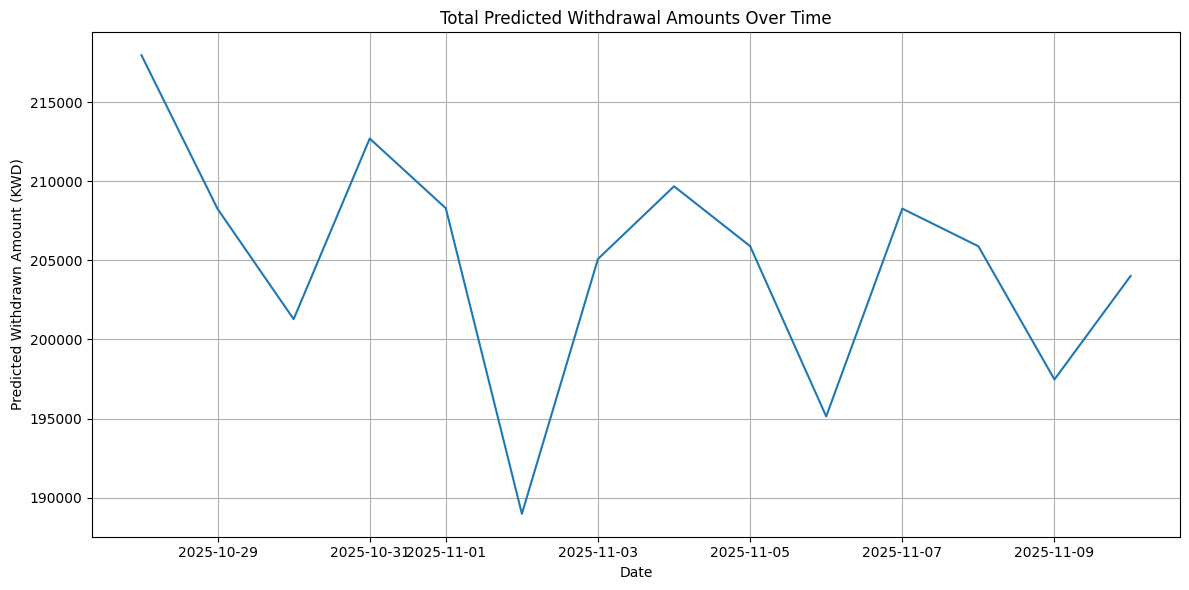

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'dt' is datetime type
predictions_df['dt'] = pd.to_datetime(predictions_df['dt'])

# Aggregate predicted withdrawal amounts by date
daily_predicted_withdrawal = predictions_df.groupby('dt')['predicted_withdrawn_kwd'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='dt', y='predicted_withdrawn_kwd', data=daily_predicted_withdrawal)
plt.title('Total Predicted Withdrawal Amounts Over Time')
plt.xlabel('Date')
plt.ylabel('Predicted Withdrawn Amount (KWD)')
plt.grid(True)
plt.tight_layout()
plt.show()

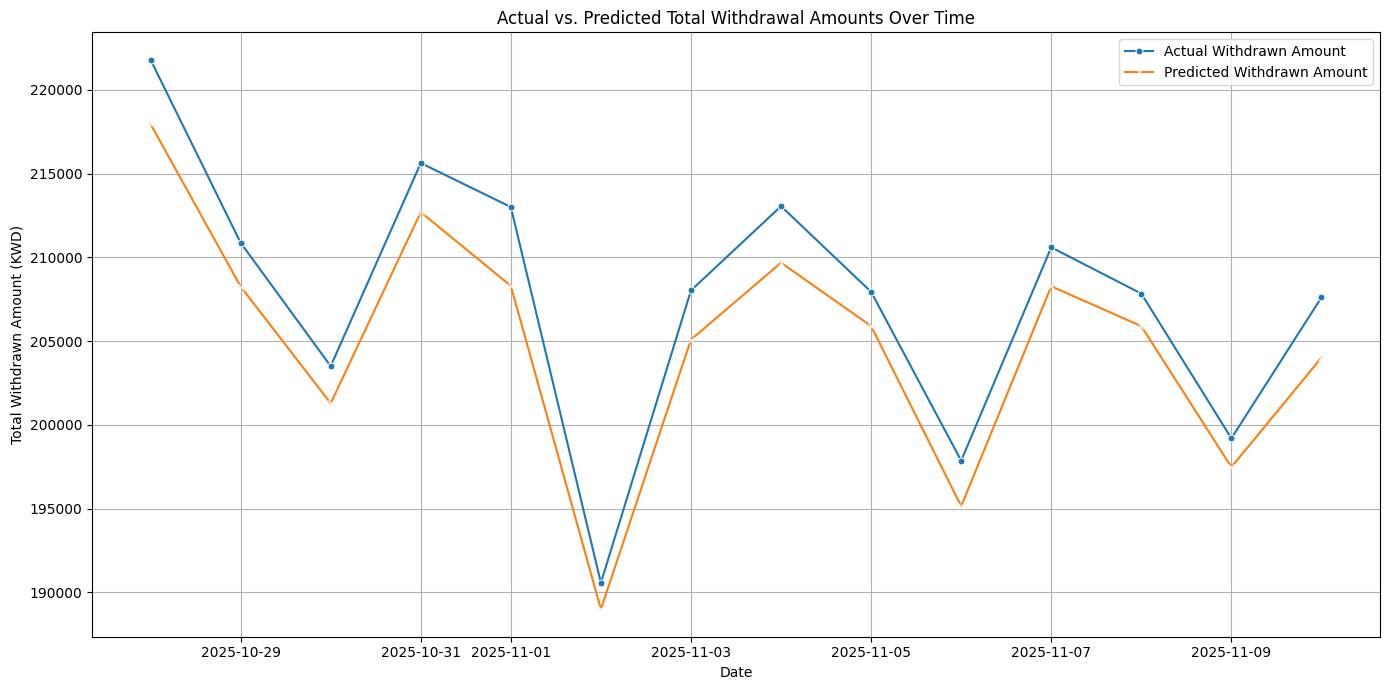

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the actual test data
TEST_PATH_RAW = '/content/drive/MyDrive/Data Science Data/atm_transactions_test-master.csv'
actual_df = pd.read_csv(TEST_PATH_RAW)
actual_df['dt'] = pd.to_datetime(actual_df['dt'])

# Aggregate actual withdrawal amounts by date
daily_actual_withdrawal = actual_df.groupby('dt')['total_withdrawn_amount_kwd'].sum().reset_index()
daily_actual_withdrawal = daily_actual_withdrawal.rename(columns={'total_withdrawn_amount_kwd': 'actual_withdrawn_kwd'})

# Ensure predictions_df 'dt' is datetime type
predictions_df['dt'] = pd.to_datetime(predictions_df['dt'])

# Aggregate predicted withdrawal amounts by date
daily_predicted_withdrawal = predictions_df.groupby('dt')['predicted_withdrawn_kwd'].sum().reset_index()

# Merge actual and predicted daily totals
comparison_df = pd.merge(daily_actual_withdrawal, daily_predicted_withdrawal, on='dt', how='inner')

plt.figure(figsize=(14, 7))
sns.lineplot(x='dt', y='actual_withdrawn_kwd', data=comparison_df, label='Actual Withdrawn Amount', marker='o', markersize=5)
sns.lineplot(x='dt', y='predicted_withdrawn_kwd', data=comparison_df, label='Predicted Withdrawn Amount', marker='x', markersize=5)

plt.title('Actual vs. Predicted Total Withdrawal Amounts Over Time')
plt.xlabel('Date')
plt.ylabel('Total Withdrawn Amount (KWD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse_withdrawal_amount = np.sqrt(mean_squared_error(comparison_df['actual_withdrawn_kwd'], comparison_df['predicted_withdrawn_kwd']))

print(f"RMSE for Total Daily Withdrawal Amount: {rmse_withdrawal_amount:.2f} KWD")


RMSE for Total Daily Withdrawal Amount: 2883.34 KWD


In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae_withdrawal_amount = mean_absolute_error(comparison_df['actual_withdrawn_kwd'], comparison_df['predicted_withdrawn_kwd'])

print(f"MAE for Total Daily Withdrawal Amount: {mae_withdrawal_amount:.2f} KWD")

MAE for Total Daily Withdrawal Amount: 2753.37 KWD


(Task 3 – SHAP + Explainability)
Loads saved atm_forecast_model.pkl

Loads training data again

Rebuilds feature frame

Runs SHAP on the ensemble’s strongest model (RandomForest)

Saves:shap_summary_amount.png
shap_summary_count.png
shap_bar_amount.png
shap_bar_count.png

In [ ]:
# analysis.py

import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt

# 🟦 Copying functions and constants from train.py (cell 4Ic7pvxPmAC0)
AMOUNT_COL = "total_withdrawn_amount_kwd"
COUNT_COL = "total_withdraw_txn_count"
TRAIN_PATH = "/content/data/atm_transactions_train_clean.csv"

def load_train_daily(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["dt"] = pd.to_datetime(df["dt"])
    df["reported_dt"] = pd.to_datetime(df["reported_dt"])
    if "report_delay_days" not in df.columns:
        df["report_delay_days"] = (df["reported_dt"] - df["dt"]).dt.days
        df["report_delay_days"] = df["report_delay_days"].fillna(0).astype(int)
    agg = df.groupby(["atm_id", "dt"], as_index=False).agg(
        {
            AMOUNT_COL: "sum",
            COUNT_COL: "sum",
            "total_deposited_amount_kwd": "sum",
            "total_deposit_txn_count": "sum",
            "report_delay_days": "mean",
        }
    )
    return agg

def load_metadata(path: str) -> pd.DataFrame:
    meta = pd.read_csv(path)
    meta["installed_date"] = pd.to_datetime(meta["installed_date"], errors="coerce")
    meta["decommissioned_date"] = pd.to_datetime(
        meta["decommissioned_date"], errors="coerce"
    )
    return meta

def load_calendar(path: str) -> pd.DataFrame:
    cal = pd.read_csv(path)
    cal["dt"] = pd.to_datetime(cal["dt"])
    if "holiday_name" in cal.columns:
        cal = cal.drop(columns=["holiday_name"])
    return cal

def load_replenishment(path: str) -> pd.DataFrame:
    rep = pd.read_csv(path)
    rep["dt"] = pd.to_datetime(rep["dt"])
    if "notes" in rep.columns:
        rep = rep.drop(columns=["notes"])
    rep = rep.groupby(["atm_id", "dt"], as_index=False).agg(
        {
            "starting_cash_kwd": "last",
            "withdrawn_kwd": "sum",
            "deposited_kwd": "sum",
            "replenished_kwd": "sum",
            "ending_cash_kwd": "last",
            "cashout_flag": "max",
        }
    )
    rep = rep.sort_values(["atm_id", "dt"])
    rep["days_since_last_replenish"] = (
        rep.groupby("atm_id")["dt"].diff().dt.days
    )
    rep["days_since_last_replenish"] = rep["days_since_last_replenish"].fillna(0)
    return rep

def build_feature_frame(
    daily: pd.DataFrame,
    calendar: pd.DataFrame,
    meta: pd.DataFrame,
    repl: pd.DataFrame,
    history_stats: dict,
) -> pd.DataFrame:
    df = daily.copy()
    df = df.merge(calendar, on="dt", how="left")
    df = df.merge(meta, on="atm_id", how="left")
    df["atm_age_days"] = (df["dt"] - df["installed_date"]).dt.days
    df["atm_age_days"] = df["atm_age_days"].clip(lower=0)
    df["is_active"] = 1
    mask_decom = (~df["decommissioned_date"].isna()) & (
        df["dt"] > df["decommissioned_date"]
    )
    df.loc[mask_decom, "is_active"] = 0
    df = df.merge(repl, on=["atm_id", "dt"], how="left")
    for col in [
        "starting_cash_kwd",
        "withdrawn_kwd",
        "deposited_kwd",
        "replenished_kwd",
        "ending_cash_kwd",
        "cashout_flag",
        "days_since_last_replenish",
    ]:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    df["day_of_week"] = df["dt"].dt.weekday
    df = df.merge(history_stats["atm_stats"], on="atm_id", how="left")
    df = df.merge(
        history_stats["atm_dow_stats"],
        on=["atm_id", "day_of_week"],
        how="left",
    )
    df = df.merge(
        history_stats["region_dow_stats"],
        on=["region", "day_of_week"],
        how="left",
    )
    hist_cols = [
        "atm_mean_amount_kwd",
        "atm_mean_txn_count",
        "atm_dow_mean_amount_kwd",
        "atm_dow_mean_txn_count",
        "region_dow_mean_amount_kwd",
        "region_dow_mean_txn_count",
    ]
    for c in hist_cols:
        if c in df.columns:
            df[c] = df[c].fillna(0)

    drop_text = []
    for col in ["name", "notes"]:
        if col in df.columns:
            drop_text.append(col)
    df = df.drop(columns=drop_text, errors="ignore")

    # Fill any remaining NaNs in numeric columns after all merges and calculations
    numeric_cols = df.select_dtypes(include=np.number).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)

    return df

# Corrected paths for aux data
CAL_PATH = "/content/data/calendar_cleaned.csv"
META_PATH = "/content/data/atm_metadata_cleaned.csv"
REPL_PATH = "/content/data/cash_replenishment_cleaned.csv"


def main():

    # -------------------------
    # Load trained model bundle
    # -------------------------
    bundle = joblib.load("atm_forecast_model_task.pkl")

    rf_amount = bundle["rf_amount"]
    rf_count = bundle["rf_count"]
    feature_cols = bundle["feature_columns"]
    history_stats = bundle["history_stats"]

    # -------------------------
    # Rebuild training data
    # -------------------------
    train_daily = load_train_daily(TRAIN_PATH)
    meta = load_metadata(META_PATH)
    cal = load_calendar(CAL_PATH)
    repl = load_replenishment(REPL_PATH)

    # Build feature frame
    full_train = build_feature_frame(train_daily, cal, meta, repl, history_stats)

    # Drop info columns (same as train)
    drop_cols = [
        "dt",
        "atm_id",
        "installed_date",
        "decommissioned_date",
        AMOUNT_COL,
        COUNT_COL,
        "reported_dt",
    ]
    X = full_train.drop(columns=drop_cols, errors="ignore")

    # one-hot, fills already handled inside train
    # just ensure columns match
    X = pd.get_dummies(X)
    X = X.reindex(columns=feature_cols, fill_value=0)

    # -------------------------
    # SHAP EXPLAINER
    # -------------------------
    print("Running SHAP explainability...")

    explainer_amt = shap.TreeExplainer(rf_amount)
    shap_values_amt = explainer_amt.shap_values(X)

    explainer_cnt = shap.TreeExplainer(rf_count)
    shap_values_cnt = explainer_cnt.shap_values(X)

    # -------------------------
    # Summary Plot (Amount)
    # -------------------------
    plt.figure()
    shap.summary_plot(shap_values_amt, X, show=False)
    plt.tight_layout()
    plt.savefig("shap_summary_amount.png")
    plt.close()

    # Bar plot (Amount)
    plt.figure()
    shap.summary_plot(shap_values_amt, X, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig("shap_bar_amount.png")
    plt.close()

    # -------------------------
    # Summary Plot (Count)
    # -------------------------
    plt.figure()
    shap.summary_plot(shap_values_cnt, X, show=False)
    plt.tight_layout()
    plt.savefig("shap_summary_count.png")
    plt.close()

    # Bar plot (Count)
    plt.figure()
    shap.summary_plot(shap_values_cnt, X, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig("shap_bar_count.png")
    plt.close()

    print("Saved SHAP analysis plots.")


if __name__ == "__main__":
    main()

Running SHAP explainability...


In [ ]:
!pip install shap

In [ ]:
# analysis.py
"""
Task 3 - Explainability & Business Insights

This script:
 - Loads trained ML models from ml_models_task2.pkl
 - Rebuilds the feature matrix on training data (same as Task 2)
 - Computes:
    * RandomForest feature importance (global)
    * Permutation importance (sample-based)
    * SHAP values (sample-based)
    * Region-level business summary (actual vs predicted + RMSE)
 - Saves CSVs and PNG plots for use in the Task 3 report.
"""

import math
from pathlib import Path
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib # Changed from pickle to joblib
from sklearn.inspection import permutation_importance

# Import the models used in the saved bundle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# Ensure these modules are reloaded to make sure classes are available for pickle.load
import sklearn.ensemble
import sklearn.linear_model
importlib.reload(sklearn.ensemble)
importlib.reload(sklearn.linear_model)

import shap  # make sure: pip install shap


# -------------------------
# Paths
# -------------------------
TRAIN_CLEAN_PATH = Path("/content/data/atm_transactions_train_clean.csv") # Corrected path
CALENDAR_PATH = Path("/content/data/calendar_cleaned.csv") # Corrected path
META_PATH = Path("/content/data/atm_metadata_cleaned.csv") # Corrected path
REPL_PATH = Path("/content/data/cash_replenishment_cleaned.csv") # Corrected path
MODEL_PATH = Path("/content/atm_forecast_model_task.pkl")

OUT_FI_AMOUNT_CSV = Path("feature_importance_amount.csv")
OUT_FI_COUNT_CSV = Path("feature_importance_count.csv")
OUT_FI_AMOUNT_PNG = Path("feature_importance_amount.png")
OUT_FI_COUNT_PNG = Path("feature_importance_count.png")

OUT_PERM_AMOUNT_CSV = Path("permutation_importance_amount.csv")
OUT_PERM_COUNT_CSV = Path("permutation_importance_count.csv")

OUT_REGION_SUMMARY = Path("region_level_summary.csv")

OUT_SHAP_SUMMARY_AMOUNT = Path("shap_summary_amount.png")
OUT_SHAP_BAR_AMOUNT = Path("shap_bar_amount.png")
OUT_SHAP_SUMMARY_COUNT = Path("shap_summary_count.png")
OUT_SHAP_BAR_COUNT = Path("shap_bar_count.png")


# -------------------------
# Utility functions
# -------------------------
def rmse(y_true, y_pred):
    return math.sqrt(((y_true - y_pred) ** 2).mean())


def ensure_meta_date_cols(meta: pd.DataFrame) -> pd.DataFrame:
    """
    Handle possible variations in metadata date column names.
    Expected: installed_date, decommissioned_date
    Fallback: installation_date, decommission_date
    """
    meta = meta.copy()

    if "installed_date" not in meta.columns and "installation_date" in meta.columns:
        meta = meta.rename(columns={"installation_date": "installed_date"})
    if "decommissioned_date" not in meta.columns and "decommission_date" in meta.columns:
        meta = meta.rename(columns={"decommission_date": "decommissioned_date"})

    if "installed_date" in meta.columns:
        meta["installed_date"] = pd.to_datetime(meta["installed_date"], errors="coerce")
    else:
        meta["installed_date"] = pd.NaT

    if "decommissioned_date" in meta.columns:
        meta["decommissioned_date"] = pd.to_datetime(
            meta["decommissioned_date"], errors="coerce"
        )
    else:
        meta["decommissioned_date"] = pd.NaT

    return meta


def build_train_features_for_analysis(
    trans: pd.DataFrame,
    calendar: pd.DataFrame,
    meta: pd.DataFrame,
    repl: pd.DataFrame,
):
    """
    Build feature matrix X and targets y_amount, y_count for analysis.
    This mirrors the feature-building logic of Task 2 (train_task2.py).
    """

    df = trans.copy()

    # --- parse dates ---
    df["dt"] = pd.to_datetime(df["dt"], errors="coerce")
    calendar = calendar.copy()
    repl = repl.copy()
    meta = ensure_meta_date_cols(meta)

    calendar["dt"] = pd.to_datetime(calendar["dt"], errors="coerce")
    repl["dt"] = pd.to_datetime(repl["dt"], errors="coerce")

    # --- merge calendar ---
    df = df.merge(calendar, on="dt", how="left", suffixes=("", "_cal"))

    # --- merge metadata ---
    df = df.merge(meta, on="atm_id", how="left", suffixes=("", "_meta"))

    # ATM age (days since installation)
    df["atm_age_days"] = (df["dt"] - df["installed_date"]).dt.days
    df["atm_age_days"] = df["atm_age_days"].fillna(0).clip(lower=0)

    # --- merge replenishment info ---
    repl_small = repl[
        [
            "dt",
            "atm_id",
            "starting_cash_kwd",
            "replenished_kwd",
            "ending_cash_kwd",
            "cashout_flag",
        ]
    ].copy()
    df = df.merge(repl_small, on=["dt", "atm_id"], how="left")

    # Fill replenishment NaNs as 0
    for col in [
        "starting_cash_kwd",
        "replenished_kwd",
        "ending_cash_kwd",
        "cashout_flag",
    ]:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    # --- per-ATM stats (aggregated features) ---
    stats = df.groupby("atm_id").agg(
        atm_mean_withdraw=("total_withdrawn_amount_kwd", "mean"),
        atm_std_withdraw=("total_withdrawn_amount_kwd", "std"),
        atm_mean_count=("total_withdraw_txn_count", "mean"),
        atm_std_count=("total_withdraw_txn_count", "std"),
    ).reset_index()

    df = df.merge(stats, on="atm_id", how="left")
    df["atm_std_withdraw"] = df["atm_std_withdraw"].fillna(0)
    df["atm_std_count"] = df["atm_std_count"].fillna(0)

    # --- boolean calendar flags to 0/1 ---
    bool_cols = ["is_weekend", "is_public_holiday", "is_salary_disbursement", "is_ramadan"]
    for c in bool_cols:
        if c in df.columns:
            df[c] = df[c].fillna(False).astype(int)

    # --- fill numeric NaNs with 0 ---
    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    df[num_cols] = df[num_cols].fillna(0)

    # --- categorical columns to encode ---
    cat_cols = []
    for c in ["region", "location_type", "holiday_name", "name"]:
        if c in df.columns:
            cat_cols.append(c)

    for c in cat_cols:
        df[c] = df[c].fillna("Unknown")

    # Targets
    y_amount = df["total_withdrawn_amount_kwd"].astype(float)
    y_count = df["total_withdraw_txn_count"].astype(float)

    # Keep dt and atm_id for business insights
    dt_series = df["dt"].copy()
    atm_ids = df["atm_id"].copy()

    # Drop non-feature columns
    drop_cols = [
        "total_withdrawn_amount_kwd",
        "total_withdraw_txn_count",
        "dt",
        "reported_dt",
        "dup_flag",
        "installed_date",
        "decommissioned_date",
        "notes",
        "atm_id",
        "region_meta",  # if present after merge
    ]
    for c in drop_cols:
        if c in df.columns:
            df = df.drop(columns=c)

    # One-hot encoding for categorical features
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    return df_encoded, y_amount, y_count, dt_series, atm_ids


def plot_top_features(feature_importances, feature_names, top_n, title, out_path):
    """
    Create horizontal bar plot for top N features and save as PNG.
    """
    feature_importances = np.array(feature_importances)
    feature_names = np.array(feature_names)

    idx = np.argsort(feature_importances)[::-1][:top_n]
    top_scores = feature_importances[idx]
    top_features = feature_names[idx]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_scores)), top_scores[::-1])
    plt.yticks(range(len(top_scores)), top_features[::-1])
    plt.xlabel("Feature Importance (normalized)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()


# -------------------------
# Main
# -------------------------
def main():
    # Load model artifact
    if not MODEL_PATH.exists():
        raise FileNotFoundError(f"Model artifact not found: {MODEL_PATH}")

    print(f"Loading model artifact from: {MODEL_PATH}")
    # Use joblib.load to load the model saved by joblib.dump
    artifact = joblib.load(MODEL_PATH)

    # Corrected keys to access the RandomForest models
    model_amount = artifact["rf_amount"]
    model_count = artifact["rf_count"]
    feature_cols_trained = artifact["feature_columns"]

    # Load data
    print(f"Loading training data: {TRAIN_CLEAN_PATH}")
    trans = pd.read_csv(TRAIN_CLEAN_PATH)

    print(f"Loading calendar: {CALENDAR_PATH}")
    calendar = pd.read_csv(CALENDAR_PATH)

    print(f"Loading metadata: {META_PATH}")
    meta = pd.read_csv(META_PATH)

    print(f"Loading replenishment: {REPL_PATH}")
    repl = pd.read_csv(REPL_PATH)

    print("Building feature matrix for analysis...")
    X_raw, y_amount, y_count, dt_series, atm_ids = build_train_features_for_analysis(
        trans, calendar, meta, repl
    )

    # Align feature columns with those used in training
    print("Aligning feature columns with training feature set...")
    X = X_raw.reindex(columns=feature_cols_trained, fill_value=0)

    print(f"Total rows: {X.shape[0]}, features: {X.shape[1]}")

    # -----------------------------
    # 1. Global feature importance (RandomForest)
    # -----------------------------
    print("Computing global feature importance from RandomForest models...")

    fi_amount = model_amount.feature_importances_
    fi_count = model_count.feature_importances_

    # Normalize (for nicer interpretation)
    fi_amount_norm = fi_amount / fi_amount.sum()
    fi_count_norm = fi_count / fi_count.sum()

    feature_names = np.array(feature_cols_trained)

    fi_amount_df = pd.DataFrame(
        {"feature": feature_names, "importance": fi_amount_norm}
    ).sort_values("importance", ascending=False)

    fi_count_df = pd.DataFrame(
        {"feature": feature_names, "importance": fi_count_norm}
    ).sort_values("importance", ascending=False)

    print(f"Saving feature importance (amount) to: {OUT_FI_AMOUNT_CSV}")
    fi_amount_df.to_csv(OUT_FI_AMOUNT_CSV, index=False)

    print(f"Saving feature importance (count) to: {OUT_FI_COUNT_CSV}")
    fi_count_df.to_csv(OUT_FI_COUNT_CSV, index=False)

    print("Creating top-20 feature importance plots...")
    plot_top_features(
        fi_amount_norm,
        feature_names,
        top_n=20,
        title="Top 20 Features - Withdrawal Amount",
        out_path=OUT_FI_AMOUNT_PNG,
    )
    plot_top_features(
        fi_count_norm,
        feature_names,
        top_n=20,
        title="Top 20 Features - Withdrawal Count",
        out_path=OUT_FI_COUNT_PNG,
    )

    # -----------------------------
    # 2. Permutation importance (sample)
    # -----------------------------
    print("Running permutation importance on a subsample...")
    sample_size = min(max(2000, int(len(X) * 0.1)), len(X))
    sample_idx = np.random.choice(len(X), size=sample_size, replace=False)
    X_sample = X.iloc[sample_idx]
    y_amount_sample = y_amount.iloc[sample_idx]
    y_count_sample = y_count.iloc[sample_idx]

    perm_amount = permutation_importance(
        model_amount, X_sample, y_amount_sample,
        n_repeats=5, random_state=42, n_jobs=-1
    )
    perm_count = permutation_importance(
        model_count, X_sample, y_count_sample,
        n_repeats=5, random_state=42, n_jobs=-1
    )

    perm_amount_df = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": perm_amount.importances_mean,
        "importance_std": perm_amount.importances_std,
    }).sort_values("importance_mean", ascending=False)

    perm_count_df = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": perm_count.importances_mean,
        "importance_std": perm_count.importances_std,
    }).sort_values("importance_mean", ascending=False)

    print(f"Saving permutation importance (amount) to: {OUT_PERM_AMOUNT_CSV}")
    perm_amount_df.to_csv(OUT_PERM_AMOUNT_CSV, index=False)

    print(f"Saving permutation importance (count) to: {OUT_PERM_COUNT_CSV}")
    perm_count_df.to_csv(OUT_PERM_COUNT_CSV, index=False)

    # -----------------------------
    # 3. Region-level business summary
    # -----------------------------
    print("Computing region-level business summary...")

    # Predict on full training set
    pred_amount_full = model_amount.predict(X)
    pred_count_full = model_count.predict(X)

    # Attach region for each row
    meta_region = meta[["atm_id", "region"]].copy()
    meta_region["region"] = meta_region["region"].fillna("Unknown")

    region_series = (
        pd.DataFrame({"atm_id": atm_ids})
        .merge(meta_region, on="atm_id", how="left")["region"]
        .fillna("Unknown")
    )

    analysis_df = pd.DataFrame({
        "dt": dt_series,
        "atm_id": atm_ids,
        "region": region_series,
        "actual_amount": y_amount,
        "actual_count": y_count,
        "pred_amount": pred_amount_full,
        "pred_count": pred_count_full,
    })

    region_summary_rows = []
    for region_name, grp in analysis_df.groupby("region"):
        row = {
            "region": region_name,
            "total_actual_amount": grp["actual_amount"].sum(),
            "total_pred_amount": grp["pred_amount"].sum(),
            "total_actual_count": grp["actual_count"].sum(),
            "total_pred_count": grp["pred_count"].sum(),
            "rmse_amount": rmse(grp["actual_amount"], grp["pred_amount"]),
            "rmse_count": rmse(grp["actual_count"], grp["pred_count"]),
        }
        region_summary_rows.append(row)

    region_summary = pd.DataFrame(region_summary_rows)

    print(f"Saving region-level summary to: {OUT_REGION_SUMMARY}")
    region_summary.to_csv(OUT_REGION_SUMMARY, index=False)

    # -----------------------------
    # 4. SHAP explainability (sample)
    # -----------------------------
    print("Running SHAP analysis (sampling for performance)...")

    shap_sample_size = min(2000, len(X))
    X_shap = X.sample(shap_sample_size, random_state=42)

    # ---- SHAP for withdrawal amount ----
    print("Computing SHAP values for withdrawal amount...")
    explainer_amount = shap.TreeExplainer(model_amount)
    shap_values_amount = explainer_amount.shap_values(X_shap)

    print(f"Saving SHAP summary plot (amount) to: {OUT_SHAP_SUMMARY_AMOUNT}")
    shap.summary_plot(
        shap_values_amount,
        X_shap,
        show=False,
        plot_type="dot"
    )
    plt.tight_layout()
    plt.savefig(OUT_SHAP_SUMMARY_AMOUNT)
    plt.close()

    print(f"Saving SHAP bar plot (amount) to: {OUT_SHAP_BAR_AMOUNT}")
    shap.summary_plot(
        shap_values_amount,
        X_shap,
        show=False,
        plot_type="bar"
    )
    plt.tight_layout()
    plt.savefig(OUT_SHAP_BAR_AMOUNT)
    plt.close()

    # ---- SHAP for withdrawal count ----
    print("Computing SHAP values for withdrawal count...")
    explainer_count = shap.TreeExplainer(model_count)
    shap_values_count = explainer_count.shap_values(X_shap)

    print(f"Saving SHAP summary plot (count) to: {OUT_SHAP_SUMMARY_COUNT}")
    shap.summary_plot(
        shap_values_count,
        X_shap,
        show=False,
        plot_type="dot"
    )
    plt.tight_layout()
    plt.savefig(OUT_SHAP_SUMMARY_COUNT)
    plt.close()

    print(f"Saving SHAP bar plot (count) to: {OUT_SHAP_BAR_COUNT}")
    shap.summary_plot(
        shap_values_count,
        X_shap,
        show=False,
        plot_type="bar"
    )
    plt.tight_layout()
    plt.savefig(OUT_SHAP_BAR_COUNT)
    plt.close()

    print("✅ Task 3 analysis complete.")
    print("Generated files:")
    print(f" - {OUT_FI_AMOUNT_CSV}")
    print(f" - {OUT_FI_COUNT_CSV}")
    print(f" - {OUT_FI_AMOUNT_PNG}")
    print(f" - {OUT_FI_COUNT_PNG}")
    print(f" - {OUT_PERM_AMOUNT_CSV}")
    print(f" - {OUT_PERM_COUNT_CSV}")
    print(f" - {OUT_REGION_SUMMARY}")
    print(f" - {OUT_SHAP_SUMMARY_AMOUNT}")
    print(f" - {OUT_SHAP_BAR_AMOUNT}")
    print(f" - {OUT_SHAP_SUMMARY_COUNT}")
    print(f" - {OUT_SHAP_BAR_COUNT}")


if __name__ == "__main__":
    main()

Loading model artifact from: /content/atm_forecast_model_task.pkl
Loading training data: /content/data/atm_transactions_train_clean.csv
Loading calendar: /content/data/calendar_cleaned.csv
Loading metadata: /content/data/atm_metadata_cleaned.csv
Loading replenishment: /content/data/cash_replenishment_cleaned.csv
Building feature matrix for analysis...
Aligning feature columns with training feature set...
Total rows: 253531, features: 43
Computing global feature importance from RandomForest models...
Saving feature importance (amount) to: feature_importance_amount.csv
Saving feature importance (count) to: feature_importance_count.csv
Creating top-20 feature importance plots...
Running permutation importance on a subsample...
Saving permutation importance (amount) to: permutation_importance_amount.csv
Saving permutation importance (count) to: permutation_importance_count.csv
Computing region-level business summary...
Saving region-level summary to: region_level_summary.csv
Running SHAP a